In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import pyodbc
con = pyodbc.connect('DSN=ISDW')

### Useful Functions

In [2]:
def convertXY(wafer_X_Y):
    """This function takes in Product CHIPXY and converts it to Diagon ChipXY
    input: waferid/x/y (product)
    output: waferid/x/y (diagon)
    """
    x = wafer_X_Y.split('/') 
    return x[0]+'/'+str(int(x[1])-3)+'/'+str(int(x[2])+4)

In [3]:
def nineChipMean(wafer_X_Y, df):
    """Given a waferid/ChipX/ChipY, find the SCF count for that chip plus the 8 neighbors
    input: 
        wafer_X_Y = waferid/ChipX/ChipY
        df = dataframe containing SCF counts for every chip
    output:
        returns the number of SCF in all 9 chips divided by 
    """
    waferid, chipX, chipY = wafer_X_Y.split('/')
    chipX = int(chipX)
    chipY = int(chipY)
    
    neighborsCount=0
    num_chips = 0
    for neighborX in [chipX, chipX-14, chipX+14]:
        for neighborY in [chipY, chipY-11, chipY+11]:
            if ((df['WAFER_ID'] == waferid) & (df['CHIPX'] == neighborX) & (df["CHIPY"] == neighborY)).any():
                neighborsCount += int(df[(df['WAFER_ID'] == waferid) & (df['CHIPX'] == neighborX) & (df["CHIPY"] == neighborY)].SCF_COUNT)
                num_chips += 1
    if num_chips != 0:
        return neighborsCount/num_chips
    else:
        return "numchips=0"

# Start

In [4]:
# Read in raw datafile from QDAT Query
df = pd.read_csv("data/relData.csv")
#df = pd.read_csv("~/Downloads/relData.csv")

In [5]:
# Create a column that holds the waferid/x/y for Diagon on the chip
df['DG_WAFER_XY'] = df['WAFER_ID_XY'].apply(convertXY)

,LAMINATE,LEVEL,LAST_PASS_SUBSECTOR,COMPONENT_SERIAL_NUMBER,FABLOT,WAFER_ID_XY,RADIUS_CENTER_5,SORT_DESC,TEST_DATE,DG_WAFER_XY
0,LAGRANGE,ModFnl-E,1,B5184456,8IQU21017,65700N5RSEE1/133/44,D,p: Stress Fail,8/20/19,65700N5RSEE1/130/48
1,LAGRANGE,ModFnl-E,1,B5183873,8IQU21017,65700N5RSEE1/133/66,D,a: LOFFSET FAIL,8/11/19,65700N5RSEE1/130/70
2,LAGRANGE,ModFnl-E,1,B5186791,8IQU21017,65700N5RSEE1/21/33,D,O: OB_IOBIST,8/14/19,65700N5RSEE1/18/37
3,LAGRANGE,ModFnl-E,1,B5187120,8IQU21017,65700N5RSEE1/21/55,D,p: Stress Fail,8/20/19,65700N5RSEE1/18/59
4,LAGRANGE,ModFnl-E,1,B5183875,8IQU21017,65700N5RSEE1/35/22,D,p: Stress Fail,8/21/19,65700N5RSEE1/32/26
5,LAGRANGE,ModFnl-E,1,B5187121,8IQU21017,65700N5RSEE1/35/33,D,O: OB_IOBIST,8/20/19,65700N5RSEE1/32/37
6,LAGRANGE,ModFnl-E,1,B5186790,8IQU21017,65700N5RSEE1/35/66,D,:: Stress Good,8/17/19,65700N5RSEE1/32/70
7,LAGRANGE,ModFnl-E,1,B5183887,8IQU21017,65700N5RSEE1/35/77,D,p: Stress Fail,8/21/19,65700N5RSEE1/32/81
8,LAGRANGE,ModFnl-E,1,B5187148,8IQU21017,65700N5XSEA1/21/33,D,p: Stress Fail,8/20/19,65700N5XSEA1/18/37
9,LAGRANGE,ModFnl-E,1,B5187182,8IQU21017,65700N5XSEA1/21/66,D,V: EXTIO,8/21/19,65700N5XSEA1/18/70


### Pull SCF count per chip on Diagon

In [7]:
# This query pulls the SCF count per chip 

daysback = 300

SQLQuery1 = """
select substr(tw.lot_id,1,9) as lot_id_base, tw.wafer_id, tc.normalized_TestX as ChipX, tc.normalized_TestY as ChipY,
tw.wafer_id || '/' || tc.normalized_TestX || '/' || tc.normalized_TestY as DiagonXY,
case 
    when corner = 'M7125P125AA' and prc.categoryName = 'SCF' then count
    else 0
end as SCF_COUNT
from
    DMIW.PattRecChipFactR prcfr
    join DMIW_SYSTEMS.DERIVEDDATASETUP dds  on prcfr.derivedsetupkey = dds.derivedsetupkey
    join DMIW_SYSTEMS.PATTRECCATEGORY prc   on prcfr.pattRecCatKey = prc.pattRecCatKey
    join DMIW_SYSTEMS.TESTEDWAFER tw        on prcfr.testedwaferkey = tw.testedwaferkey
    join DMIW_SYSTEMS.TESTEDCHIP tc         on prcfr.testedwaferkey = tc.testedwaferkey and prcfr.testedchipkey = tc.testedchipkey
    join DMIW_SYSTEMS.GEOGRAPHY g           on prcfr.geographykey = g.geographykey
where
    tw.testedwaferkey is not null and
    categoryName <> '' and exclude_Flag = 'N' and
    corner = 'M7125P125AA' and 
    tc.normalized_testx || '_' || tc.normalized_testy not in ('4_48','4_59','144_26','130_15')
    and last_test_date > CURRENT_DATE - {} days
order by lot_Id, tw.wafer_Id, tc.normalized_TestX, tc.normalized_TestY, count
""".format(daysback)

In [8]:
df1 = pd.read_sql(SQLQuery1,con)

In [9]:
df1 =df1.groupby(['LOT_ID_BASE','DIAGONXY','WAFER_ID','CHIPX','CHIPY']).sum().reset_index()

In [10]:
df1[df1.LOT_ID_BASE == '8IQU21017'].head(10)

,LOT_ID_BASE,DIAGONXY,WAFER_ID,CHIPX,CHIPY,SCF_COUNT
259912,8IQU21017,65700N5RSEE1/102/15,65700N5RSEE1,102,15,2
259913,8IQU21017,65700N5RSEE1/102/37,65700N5RSEE1,102,37,6
259914,8IQU21017,65700N5RSEE1/102/70,65700N5RSEE1,102,70,9
259915,8IQU21017,65700N5RSEE1/116/26,65700N5RSEE1,116,26,7
259916,8IQU21017,65700N5RSEE1/116/48,65700N5RSEE1,116,48,10
259917,8IQU21017,65700N5RSEE1/116/59,65700N5RSEE1,116,59,9
259918,8IQU21017,65700N5RSEE1/116/81,65700N5RSEE1,116,81,0
259919,8IQU21017,65700N5RSEE1/130/37,65700N5RSEE1,130,37,1
259920,8IQU21017,65700N5RSEE1/130/70,65700N5RSEE1,130,70,1
259921,8IQU21017,65700N5RSEE1/144/48,65700N5RSEE1,144,48,0


### Join the reliability data to the SCF chip data by Diagon Wafer/ChipX/ChipY

In [11]:
df2 = df.set_index('DG_WAFER_XY').join(df1.set_index('DIAGONXY')).reset_index()

In [12]:
df2

,DG_WAFER_XY,LAMINATE,LEVEL,LAST_PASS_SUBSECTOR,COMPONENT_SERIAL_NUMBER,FABLOT,WAFER_ID_XY,RADIUS_CENTER_5,SORT_DESC,TEST_DATE,LOT_ID_BASE,WAFER_ID,CHIPX,CHIPY,SCF_COUNT
0,65700N5RSEE1/130/48,LAGRANGE,ModFnl-E,1,B5184456,8IQU21017,65700N5RSEE1/133/44,D,p: Stress Fail,8/20/19,NaN,NaN,NaN,NaN,NaN
1,65700N5RSEE1/130/70,LAGRANGE,ModFnl-E,1,B5183873,8IQU21017,65700N5RSEE1/133/66,D,a: LOFFSET FAIL,8/11/19,8IQU21017,65700N5RSEE1,130.0,70.0,1.0
2,65700N5RSEE1/18/37,LAGRANGE,ModFnl-E,1,B5186791,8IQU21017,65700N5RSEE1/21/33,D,O: OB_IOBIST,8/14/19,8IQU21017,65700N5RSEE1,18.0,37.0,0.0
3,65700N5RSEE1/18/59,LAGRANGE,ModFnl-E,1,B5187120,8IQU21017,65700N5RSEE1/21/55,D,p: Stress Fail,8/20/19,NaN,NaN,NaN,NaN,NaN
4,65700N5RSEE1/32/26,LAGRANGE,ModFnl-E,1,B5183875,8IQU21017,65700N5RSEE1/35/22,D,p: Stress Fail,8/21/19,8IQU21017,65700N5RSEE1,32.0,26.0,0.0
5,65700N5RSEE1/32/37,LAGRANGE,ModFnl-E,1,B5187121,8IQU21017,65700N5RSEE1/35/33,D,O: OB_IOBIST,8/20/19,NaN,NaN,NaN,NaN,NaN
6,65700N5RSEE1/32/70,LAGRANGE,ModFnl-E,1,B5186790,8IQU21017,65700N5RSEE1/35/66,D,:: Stress Good,8/17/19,NaN,NaN,NaN,NaN,NaN
7,65700N5RSEE1/32/81,LAGRANGE,ModFnl-E,1,B5183887,8IQU21017,65700N5RSEE1/35/77,D,p: Stress Fail,8/21/19,NaN,NaN,NaN,NaN,NaN
8,65700N5XSEA1/18/37,LAGRANGE,ModFnl-E,1,B5187148,8IQU21017,65700N5XSEA1/21/33,D,p: Stress Fail,8/20/19,8IQU21017,65700N5XSEA1,18.0,37.0,0.0
9,65700N5XSEA1/18/70,LAGRANGE,ModFnl-E,1,B5187182,8IQU21017,65700N5XSEA1/21/66,D,V: EXTIO,8/21/19,8IQU21017,65700N5XSEA1,18.0,70.0,0.0


### Calculate the 9chipmean for each chip in our dataframe

In [13]:
df2['9chipmean'] = df2['DG_WAFER_XY'].apply(lambda x: nineChipMean(x, df1))

In [14]:
def passfail(x):
    if x == ":: Stress Good":
        return 'Pass'
    else:
        return 'Fail'

df2['Pass/Fail'] = df2.SORT_DESC.apply(passfail)

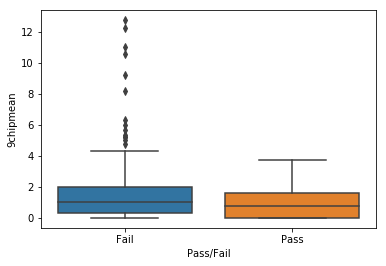

In [15]:
sns.boxplot(x='Pass/Fail',y='9chipmean',data=df2)

In [16]:
df2[df2['Pass/Fail'] == 'Pass']['9chipmean'].describe()

count    45.000000
mean      1.062963
std       1.079813
min       0.000000
25%       0.000000
50%       0.750000
75%       1.600000
max       3.750000
Name: 9chipmean, dtype: float64

In [17]:
df2[df2['Pass/Fail'] == 'Fail']['9chipmean'].describe()

count    265.000000
mean       1.492453
std        1.902839
min        0.000000
25%        0.333333
50%        1.000000
75%        2.000000
max       12.750000
Name: 9chipmean, dtype: float64

In [18]:
df2

,DG_WAFER_XY,LAMINATE,LEVEL,LAST_PASS_SUBSECTOR,COMPONENT_SERIAL_NUMBER,FABLOT,WAFER_ID_XY,RADIUS_CENTER_5,SORT_DESC,TEST_DATE,LOT_ID_BASE,WAFER_ID,CHIPX,CHIPY,SCF_COUNT,9chipmean,Pass/Fail
0,65700N5RSEE1/130/48,LAGRANGE,ModFnl-E,1,B5184456,8IQU21017,65700N5RSEE1/133/44,D,p: Stress Fail,8/20/19,NaN,NaN,NaN,NaN,NaN,4.200000,Fail
1,65700N5RSEE1/130/70,LAGRANGE,ModFnl-E,1,B5183873,8IQU21017,65700N5RSEE1/133/66,D,a: LOFFSET FAIL,8/11/19,8IQU21017,65700N5RSEE1,130.0,70.0,1.0,2.750000,Fail
2,65700N5RSEE1/18/37,LAGRANGE,ModFnl-E,1,B5186791,8IQU21017,65700N5RSEE1/21/33,D,O: OB_IOBIST,8/14/19,8IQU21017,65700N5RSEE1,18.0,37.0,0.0,0.000000,Fail
3,65700N5RSEE1/18/59,LAGRANGE,ModFnl-E,1,B5187120,8IQU21017,65700N5RSEE1/21/55,D,p: Stress Fail,8/20/19,NaN,NaN,NaN,NaN,NaN,0.333333,Fail
4,65700N5RSEE1/32/26,LAGRANGE,ModFnl-E,1,B5183875,8IQU21017,65700N5RSEE1/35/22,D,p: Stress Fail,8/21/19,8IQU21017,65700N5RSEE1,32.0,26.0,0.0,2.000000,Fail
5,65700N5RSEE1/32/37,LAGRANGE,ModFnl-E,1,B5187121,8IQU21017,65700N5RSEE1/35/33,D,O: OB_IOBIST,8/20/19,NaN,NaN,NaN,NaN,NaN,2.000000,Fail
6,65700N5RSEE1/32/70,LAGRANGE,ModFnl-E,1,B5186790,8IQU21017,65700N5RSEE1/35/66,D,:: Stress Good,8/17/19,NaN,NaN,NaN,NaN,NaN,1.250000,Pass
7,65700N5RSEE1/32/81,LAGRANGE,ModFnl-E,1,B5183887,8IQU21017,65700N5RSEE1/35/77,D,p: Stress Fail,8/21/19,NaN,NaN,NaN,NaN,NaN,1.333333,Fail
8,65700N5XSEA1/18/37,LAGRANGE,ModFnl-E,1,B5187148,8IQU21017,65700N5XSEA1/21/33,D,p: Stress Fail,8/20/19,8IQU21017,65700N5XSEA1,18.0,37.0,0.0,1.666667,Fail
9,65700N5XSEA1/18/70,LAGRANGE,ModFnl-E,1,B5187182,8IQU21017,65700N5XSEA1/21/66,D,V: EXTIO,8/21/19,8IQU21017,65700N5XSEA1,18.0,70.0,0.0,1.500000,Fail


### Look at the chips of interest to predict whether we have a problem

In [15]:
U21008 = pd.DataFrame({"WAFER_ID_XY":
["6A08C358SOF6/21/44",
"6A08F243SOE1/49/22",
"6A08C359SOC5/35/33",
"6A08I014SOF1/35/33",
"6A08C361SOC5/63/11",
"6A08C361SOC5/21/66",
"6A08F182SOE0/35/22",
"6A08F180SOC7/63/11",
"6A08F182SOE0/63/22",
"6A08I014SOF1/21/44",
"6A08F182SOE0/119/77",
"6A08F243SOE1/91/11",
"6A08F181SOH1/49/77",
"6A08C359SOC5/21/33",
"6A08F182SOE0/63/11",
"6A08I013SOA7/91/88",
"6A08I013SOA7/63/11",
"6A08I015SOC0/119/77"]
})

In [16]:
# Create a column that holds the waferid/x/y for Diagon on the chip
U21008['DG_WAFER_XY'] = U21008['WAFER_ID_XY'].apply(convertXY)

In [18]:
# Find the 9chipmean for these chips to see if they'll be okay
U21008['9chipmean'] = U21008['DG_WAFER_XY'].apply(lambda x: nineChipMean(x, df1))
U21008

,WAFER_ID_XY,DG_WAFER_XY,9chipmean
0,6A08C358SOF6/21/44,6A08C358SOF6/18/48,2.666667
1,6A08F243SOE1/49/22,6A08F243SOE1/46/26,4.500000
2,6A08C359SOC5/35/33,6A08C359SOC5/32/37,2.500000
3,6A08I014SOF1/35/33,6A08I014SOF1/32/37,3.000000
4,6A08C361SOC5/63/11,6A08C361SOC5/60/15,6.000000
5,6A08C361SOC5/21/66,6A08C361SOC5/18/70,3.000000
6,6A08F182SOE0/35/22,6A08F182SOE0/32/26,1.000000
7,6A08F180SOC7/63/11,6A08F180SOC7/60/15,2.000000
8,6A08F182SOE0/63/22,6A08F182SOE0/60/26,2.600000
9,6A08I014SOF1/21/44,6A08I014SOF1/18/48,1.333333


# Apply the same methodology to look at Product SRAM SCF count

In [20]:
WFT = pd.read_csv("/Users/acyang@us.ibm.com/Downloads/sram_count.csv")

In [21]:
# Process the dataframe
WFT['DG_WAFER_XY'] = WFT['ECID'].apply(convertXY)
WFT['CHIPX'] = WFT['DG_WAFER_XY'].apply(lambda x: int(x.split('/')[1]))
WFT['CHIPY'] = WFT['DG_WAFER_XY'].apply(lambda x: int(x.split('/')[2]))
WFT = WFT.rename(columns={"WAFER":"WAFER_ID","SCF_SUM":"SCF_COUNT"})

In [22]:
# Calculate the 9chipmean
df['9chipmean']=df['DG_WAFER_XY'].apply(lambda x: nineChipMean(x, WFT))

In [23]:
# The 9S lots were not included in the dataset hunter sent me
df[df.FABLOT=='8IQU21017']

,LAMINATE,LEVEL,LAST_PASS_SUBSECTOR,COMPONENT_SERIAL_NUMBER,FABLOT,WAFER_ID_XY,RADIUS_CENTER_5,SORT_DESC,TEST_DATE,DG_WAFER_XY,9chipmean
0,LAGRANGE,ModFnl-E,1,B5184456,8IQU21017,65700N5RSEE1/133/44,D,p: Stress Fail,8/20/19,65700N5RSEE1/130/48,numchips=0
1,LAGRANGE,ModFnl-E,1,B5183873,8IQU21017,65700N5RSEE1/133/66,D,a: LOFFSET FAIL,8/11/19,65700N5RSEE1/130/70,numchips=0
2,LAGRANGE,ModFnl-E,1,B5186791,8IQU21017,65700N5RSEE1/21/33,D,O: OB_IOBIST,8/14/19,65700N5RSEE1/18/37,numchips=0
3,LAGRANGE,ModFnl-E,1,B5187120,8IQU21017,65700N5RSEE1/21/55,D,p: Stress Fail,8/20/19,65700N5RSEE1/18/59,numchips=0
4,LAGRANGE,ModFnl-E,1,B5183875,8IQU21017,65700N5RSEE1/35/22,D,p: Stress Fail,8/21/19,65700N5RSEE1/32/26,numchips=0
5,LAGRANGE,ModFnl-E,1,B5187121,8IQU21017,65700N5RSEE1/35/33,D,O: OB_IOBIST,8/20/19,65700N5RSEE1/32/37,numchips=0
6,LAGRANGE,ModFnl-E,1,B5186790,8IQU21017,65700N5RSEE1/35/66,D,:: Stress Good,8/17/19,65700N5RSEE1/32/70,numchips=0
7,LAGRANGE,ModFnl-E,1,B5183887,8IQU21017,65700N5RSEE1/35/77,D,p: Stress Fail,8/21/19,65700N5RSEE1/32/81,numchips=0
8,LAGRANGE,ModFnl-E,1,B5187148,8IQU21017,65700N5XSEA1/21/33,D,p: Stress Fail,8/20/19,65700N5XSEA1/18/37,numchips=0
9,LAGRANGE,ModFnl-E,1,B5187182,8IQU21017,65700N5XSEA1/21/66,D,V: EXTIO,8/21/19,65700N5XSEA1/18/70,numchips=0


In [34]:
def passfail(x):
    if x == ":: Stress Good":
        return 'Pass'
    else:
        return 'Fail'

df['Pass/Fail'] = df.SORT_DESC.apply(passfail)

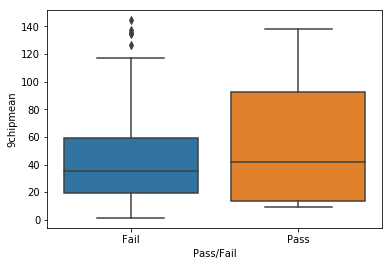

In [44]:
temp9chipmean = df[df['9chipmean'] != 'numchips=0']['9chipmean'].astype('float32')

sns.boxplot(x='Pass/Fail',y=temp9chipmean,data=df)

In [24]:
# Calculate the 9chipmean based on WFT Product SRAM SCF count
U21008['9chipmean'] = U21008['DG_WAFER_XY'].apply(lambda x: nineChipMean(x, WFT))
U21008

,WAFER_ID_XY,DG_WAFER_XY,9chipmean
0,6A08C358SOF6/21/44,6A08C358SOF6/18/48,19.750000
1,6A08F243SOE1/49/22,6A08F243SOE1/46/26,31.666667
2,6A08C359SOC5/35/33,6A08C359SOC5/32/37,63.000000
3,6A08I014SOF1/35/33,6A08I014SOF1/32/37,36.000000
4,6A08C361SOC5/63/11,6A08C361SOC5/60/15,81.000000
5,6A08C361SOC5/21/66,6A08C361SOC5/18/70,29.000000
6,6A08F182SOE0/35/22,6A08F182SOE0/32/26,17.000000
7,6A08F180SOC7/63/11,6A08F180SOC7/60/15,9.333333
8,6A08F182SOE0/63/22,6A08F182SOE0/60/26,24.000000
9,6A08I014SOF1/21/44,6A08I014SOF1/18/48,45.750000
